In [777]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [778]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [779]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [780]:
# TRAIN_DATASET_PATH = 'project/train.csv'
# TEST_DATASET_PATH = 'project/test.csv'

TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/project/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/project/test.csv'

## Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [781]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')


In [782]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')

## Приведение типов

In [783]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

## Обзор данных

### Целевая переменная

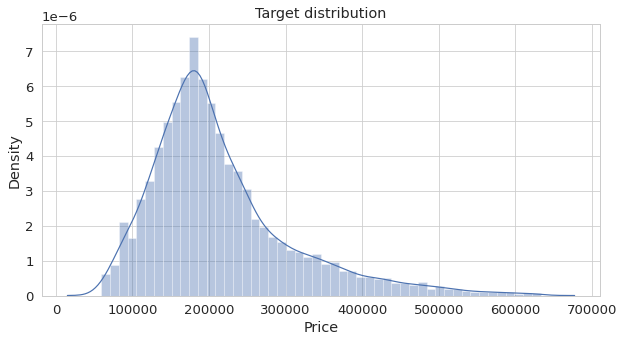

In [784]:
plt.figure(figsize = (10, 5))

sns.distplot(train_df['Price'])
plt.title('Target distribution');

### Количественные переменные

In [785]:
train_df.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [786]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [787]:
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

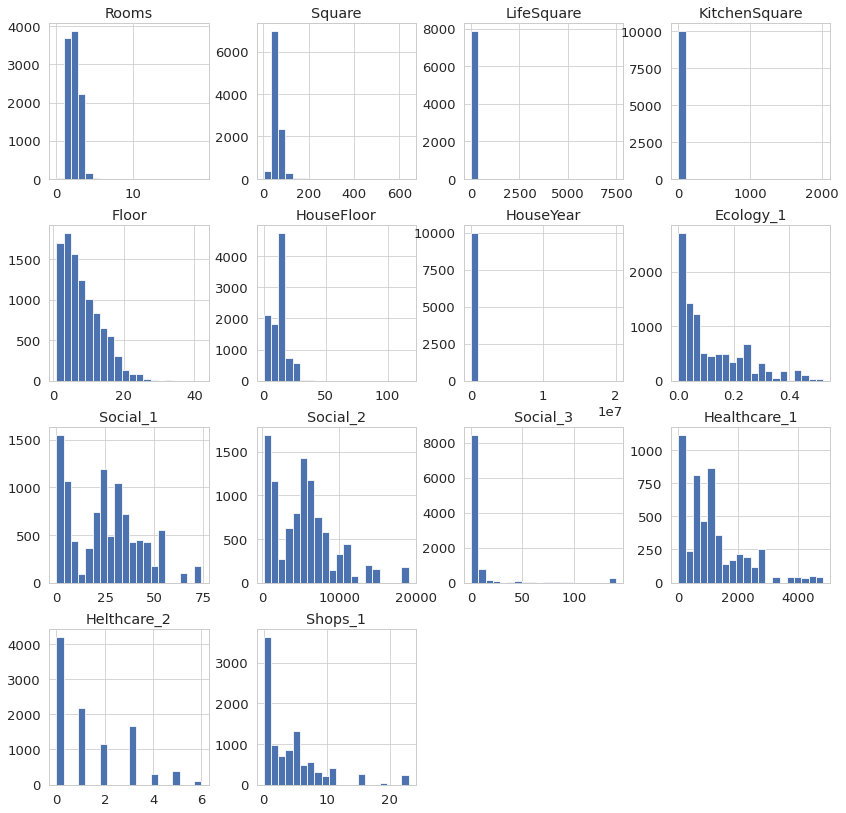

In [788]:
train_df[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

### Категориальные переменные

**Ecology_2, Ecology_3, Shops_2**

In [789]:
feature_cat_names = train_df.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [790]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

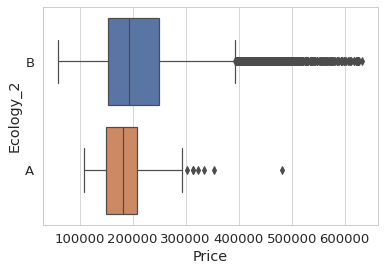

In [791]:
sns.boxplot('Price', 'Ecology_2', data=train_df);

In [792]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

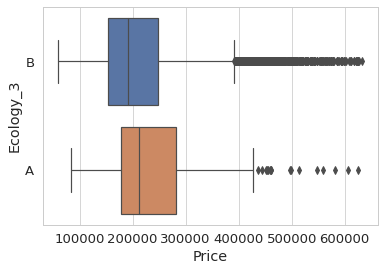

In [793]:
sns.boxplot('Price', 'Ecology_3', data=train_df);

In [794]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

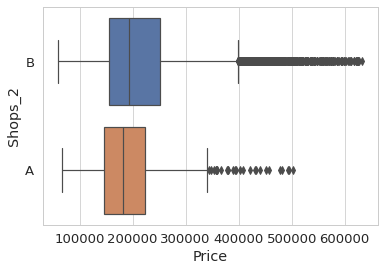

In [795]:
sns.boxplot('Price', 'Shops_2', data=train_df);

In [796]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

**Helthcare_2**

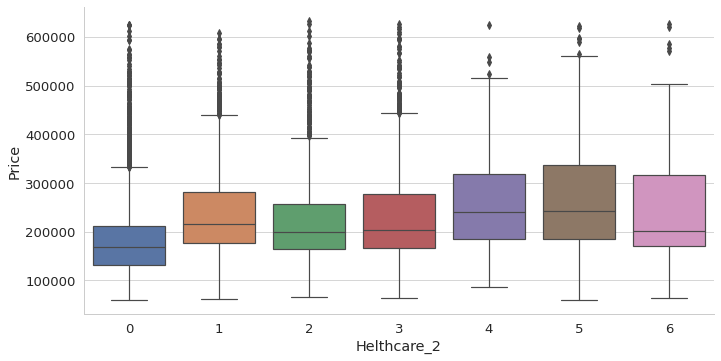

In [797]:
sns.catplot('Helthcare_2', 'Price', kind="box", data=train_df, aspect=2/1);

## Обработка пропусков

In [798]:
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

**LifeSquare** - вычисление

In [799]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = \
    train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = \
    test_df['Square'] - test_df['KitchenSquare']

**Healthcare_1** (0 вариант) - удаление

In [800]:
train_df.drop(['Healthcare_1'], axis=1, inplace=True)
test_df.drop(['Healthcare_1'], axis=1, inplace=True)

## Обработка выбросов

**Rooms**

In [801]:
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

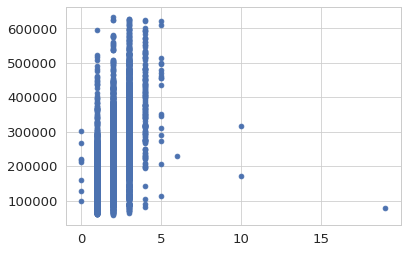

In [802]:
plt.scatter(train_df['Rooms'], train_df['Price']);

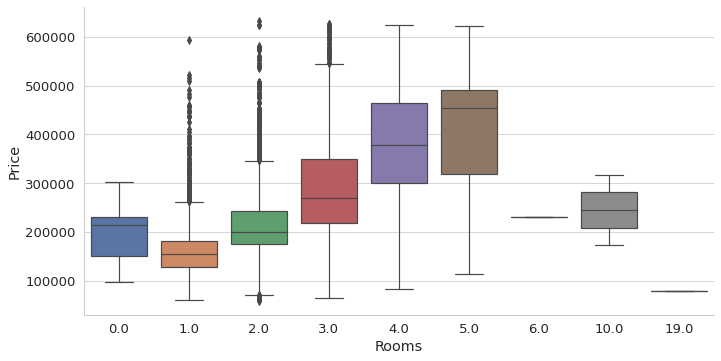

In [803]:
sns.catplot('Rooms', 'Price', kind="box", data=train_df, aspect=2/1);

In [804]:
test_df['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

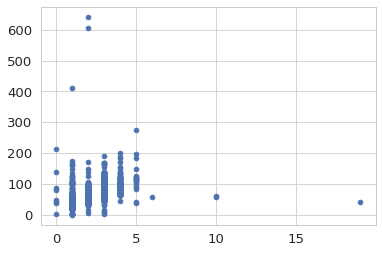

In [805]:
plt.scatter(train_df['Rooms'], train_df['Square']);

In [806]:
train_df['Rooms'].mode()[0]

2.0

In [807]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0] # !!

**Square, LifeSquare, KitchenSquare**

In [808]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,41.80,6.27
std,21.06,77.82,28.56
min,1.14,0.37,0.00
25%,41.77,25.49,1.00
50%,52.51,37.04,6.00
75%,65.90,49.82,9.00
max,641.07,"7,480.59","2,014.00"


In [809]:
train_df['KitchenSquare'].value_counts()

1.00      2460
8.00      1306
5.00      1169
10.00     1075
6.00      1038
          ... 
73.00        1
123.00       1
31.00        1
53.00        1
54.00        1
Name: KitchenSquare, Length: 58, dtype: int64

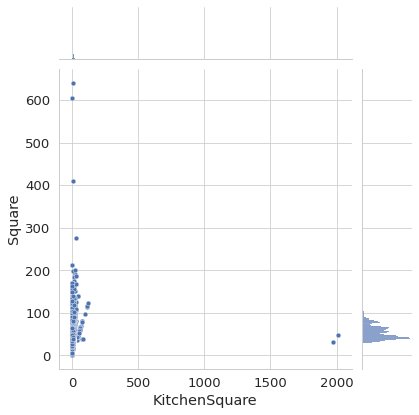

In [810]:
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind='scatter', height=6);

In [811]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,"2,014.00",4,1.00,2014,0.07,1,1,2,629,1,0,0,0,"108,337.48"
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,1,1,21,5731,0,1,0,1,"160,488.03"
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,1,1,4,915,0,0,0,1,"99,079.96"
14679,81,1.00,32.28,19.28,"1,970.00",6,1.00,1977,0.01,1,1,30,5285,0,6,6,1,"105,539.56"


In [812]:
train_df['KitchenSquare'].median()

6.0

In [813]:
train_df.loc[(train_df['KitchenSquare'] > 150) | \
             (train_df['KitchenSquare'] > train_df['Square']),
             'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[(test_df['KitchenSquare'] > 150) | \
            (test_df['KitchenSquare'] > test_df['Square']),
            'KitchenSquare'] = train_df['KitchenSquare'].median()

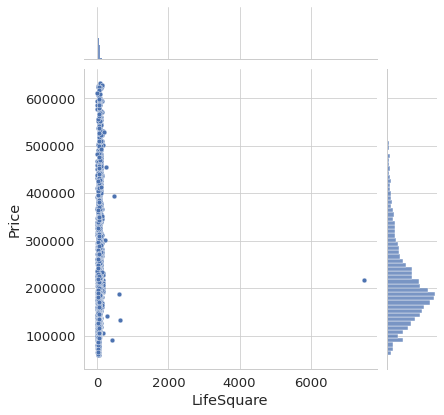

In [814]:
sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='scatter', height=6);

In [815]:
train_df.loc[(train_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()
test_df.loc[(test_df['LifeSquare'] > 400), 'LifeSquare'] = \
        train_df['LifeSquare'].median()

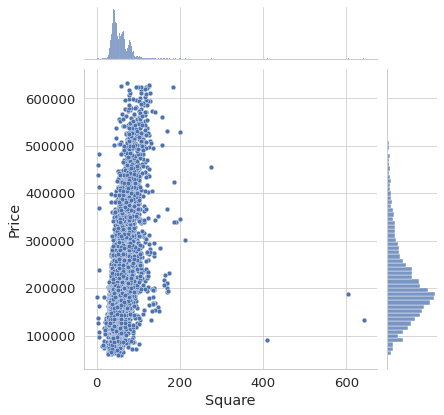

In [816]:
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6);

In [817]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,1,1,43,8429,3,3,9,1,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,1,1,4,915,0,0,0,1,"107,604.27"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,0,0,1,"137,597.60"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,1,1,9,1892,0,0,1,1,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,1,1,16,3433,4,4,5,1,"369,472.40"
28,9,2.00,604.71,37.04,1.00,17,18.00,1977,0.16,1,1,25,5648,1,2,4,1,"187,717.24"
2307,102,1.00,409.43,37.04,10.00,4,4.00,2016,0.24,1,1,26,3889,6,3,6,1,"90,470.43"
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,0,0,1,"126,596.94"
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,1,1,9,1892,0,0,1,1,"161,379.07"


In [818]:
train_df['Square'].median()

52.51330992401352

In [819]:
(train_df['Square'] / train_df['Rooms']).median()

30.82149803272398

In [820]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

In [821]:
len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])

830

In [822]:
train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,0,5,1,"175,616.23"
8054,23,1.00,42.53,43.97,1.00,3,9.00,2014,0.03,1,1,0,168,0,0,0,1,"95,338.20"
10521,38,3.00,104.21,106.34,0.00,20,0.00,2017,0.06,1,1,15,2787,2,0,7,1,"435,462.05"
7596,23,1.00,47.08,46.81,12.00,3,9.00,1977,0.01,1,1,2,475,0,0,0,1,"96,029.17"
2301,1,2.00,61.40,65.22,0.00,17,22.00,2016,0.01,1,1,1,264,0,0,1,1,"199,215.45"


In [823]:
#train_df.loc[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']), 'Square'] = \
#    train_df['LifeSquare'] + train_df['KitchenSquare']

#test_df.loc[(test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare']), 'Square'] = \
#    test_df['LifeSquare'] + test_df['KitchenSquare']

In [824]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.22,40.86,5.86
std,19.06,20.57,5.07
min,13.78,0.37,0.00
25%,41.79,25.49,1.00
50%,52.51,37.04,6.00
75%,65.89,49.77,9.00
max,275.65,263.54,123.00


In [825]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=train_df['Square'],
    y=train_df['LifeSquare'],
    z=train_df['KitchenSquare'], 
    mode='markers',
    marker=dict(
        size=5,
        color=train_df['Price'], 
        colorscale='jet',  
        colorbar=dict(thickness=10),
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Square',
        yaxis_title='LifeSquare',
        zaxis_title='KitchenSquare'),
    )

fig.show()

**HouseFloor, Floor**

In [826]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [827]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

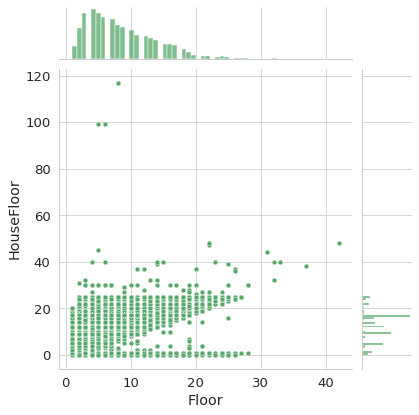

In [828]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=6, color='g');

In [829]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [830]:
train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [831]:
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [832]:
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [833]:
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
6731         2020
8892         2020
14318        2020
           ...   
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [834]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011

## Обработка редких категорий

**DistrictId**

In [835]:
print(train_df['DistrictId'].nunique(), ' уникальных  значений в train')
print(test_df['DistrictId'].nunique(), ' уникальных  значений в test')

205  уникальных  значений в train
201  уникальных  значений в test


In [836]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,209,1
201,117,1
202,199,1
203,174,1


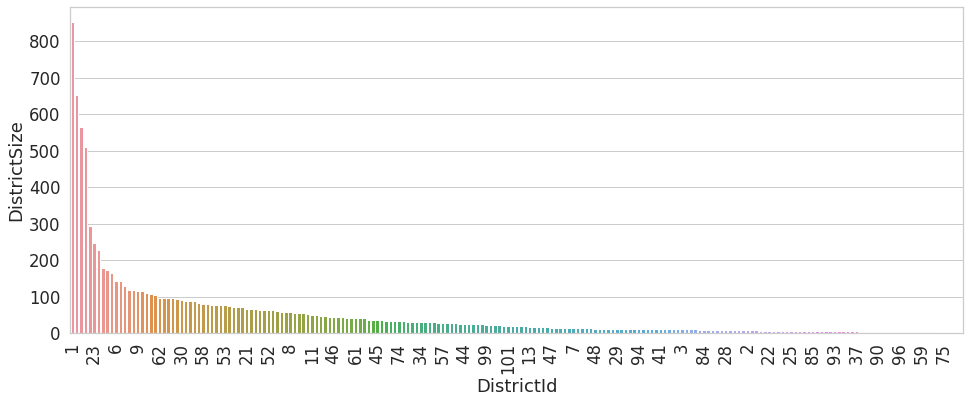

In [837]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [838]:
district_size.loc[district_size['DistrictSize'] > 100, :]

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


In [839]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

In [840]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,999,15
1,1,652
2,11,129
3,21,165
4,23,565
5,27,851
6,30,228
7,34,111
8,44,104
9,45,116


In [841]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [842]:
test_df['DistrictId'].value_counts()

999    2551
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
8        64
61       64
46       61
74       61
34       61
57       54
45       49
44       46
11       45
Name: DistrictId, dtype: int64

## Построение новых признаков

**DistrictSize** - Frequency Encoding

In [843]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
Id,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,0,11,1,"184,966.93",15
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,1,16,1,"300,009.45",15
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,1,3,1,"220,925.91",174
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,0,5,1,"175,616.23",179
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,2,4,1,"150,226.53",15


**PriceOneRoom**

In [844]:
train_df['PriceOneRoom'] = train_df['Price'] / train_df['Rooms']

In [845]:
train_df['PriceOneRoom'].describe()

count    10,000.00
mean    124,245.13
std      50,723.97
min      20,585.69
25%      89,449.16
50%     114,961.11
75%     152,997.53
max     594,565.30
Name: PriceOneRoom, dtype: float64

**PriceOneRoomByDistrict** - Likelihood Encoding

In [846]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

price_by_district

,DistrictId,PriceOneRoomByDistrict
0,999,"129,339.27"
1,1,"106,080.90"
2,11,"100,098.98"
3,21,"104,448.25"
4,23,"76,232.42"
5,27,"94,738.78"
6,30,"93,960.73"
7,34,"129,738.65"
8,44,"125,925.66"
9,45,"164,907.84"


In [847]:
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [848]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,PriceOneRoom,PriceOneRoomByDistrict
Id,,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,0,11,1,"184,966.93",15,"92,483.47","129,339.27"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,1,16,1,"300,009.45",15,"100,003.15","129,339.27"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,1,3,1,"220,925.91",174,"110,462.95","138,669.20"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,0,5,1,"175,616.23",179,"87,808.11","105,638.52"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,2,4,1,"150,226.53",15,"150,226.53","129,339.27"


**RoomSquare**

In [849]:
train_df['RoomSquare'] = train_df['Square'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['Square'] / test_df['Rooms']

**Floor_cat**

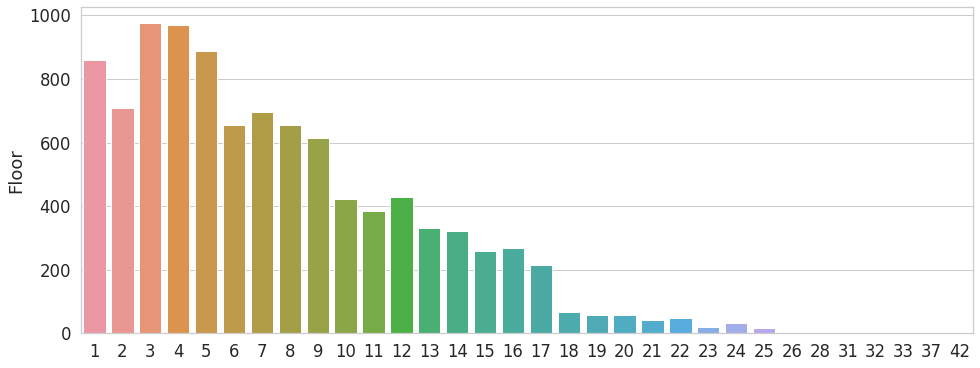

In [850]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['Floor'].value_counts(), x=train_df['Floor'].value_counts().index);

In [851]:
train_df.loc[train_df['Floor'] <= 5, 'Floor_cat'] = 1  
train_df.loc[(train_df['Floor'] > 5) & (train_df['Floor'] <= 17), 'Floor_cat'] = 2
train_df.loc[train_df['Floor'] > 17, 'Floor_cat'] = 3

test_df.loc[test_df['Floor'] <= 5, 'Floor_cat'] = 1  
test_df.loc[(test_df['Floor'] > 5) & (test_df['Floor'] <= 17), 'Floor_cat'] = 2
test_df.loc[test_df['Floor'] > 17, 'Floor_cat'] = 3

train_df['Floor_cat'].value_counts()

2.00    5249
1.00    4405
3.00     346
Name: Floor_cat, dtype: int64

In [852]:
labels = [1, 2, 3]
train_df['Floor_cat_qcut'] = pd.qcut(train_df['Floor'], q=3, labels=labels)
test_df['Floor_cat_qcut'] = pd.qcut(test_df['Floor'], q=3, labels=labels)
train_df['Floor_cat_qcut'].value_counts()

1    3517
2    3507
3    2976
Name: Floor_cat_qcut, dtype: int64

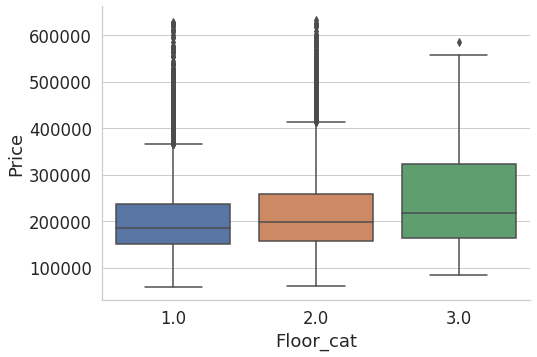

In [853]:
sns.catplot("Floor_cat", "Price", kind="box", data=train_df, aspect=3/2);

**HouseFloor_cat**

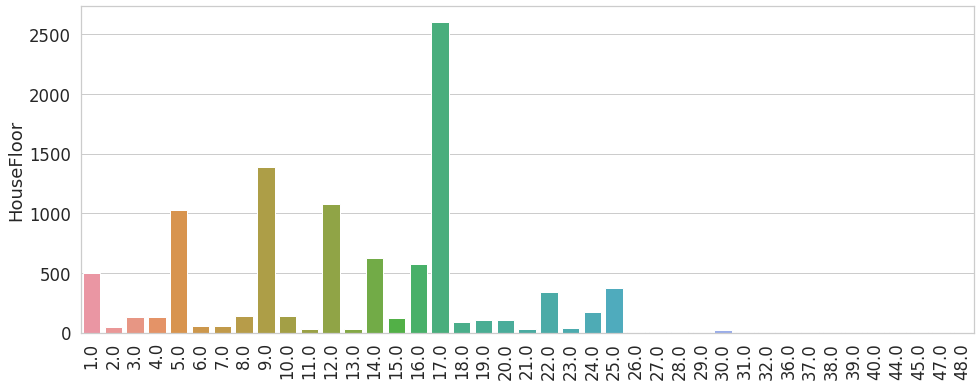

In [854]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseFloor'].value_counts(), x=train_df['HouseFloor'].value_counts().index,
#           order=train_df['HouseFloor'].value_counts().index
           );
ax.tick_params(axis='x', rotation=90)

In [855]:
train_df.loc[train_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
train_df.loc[(train_df['HouseFloor'] > 5) & (train_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 2
train_df.loc[train_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 3

test_df.loc[test_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
test_df.loc[(test_df['HouseFloor'] > 5) & (test_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 2
test_df.loc[test_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 3

train_df['HouseFloor_cat'].value_counts()

2.00    6838
1.00    1837
3.00    1325
Name: HouseFloor_cat, dtype: int64

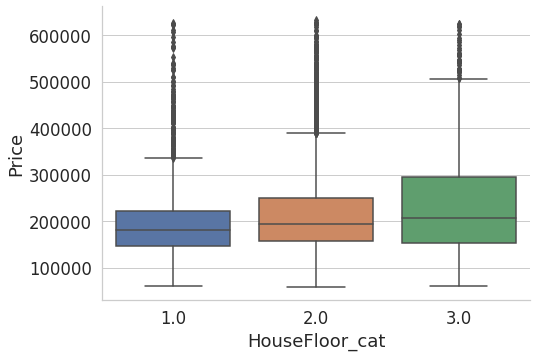

In [856]:
sns.catplot("HouseFloor_cat", "Price", kind="box", data=train_df, aspect=3/2);

In [857]:
train_df[['Floor_cat', 'HouseFloor_cat']] = train_df[['Floor_cat', 'HouseFloor_cat']].astype(int)
test_df[['Floor_cat', 'HouseFloor_cat']] = test_df[['Floor_cat', 'HouseFloor_cat']].astype(int)

## Отбор признаков

In [858]:
train_df.to_csv('train_prepared.csv')
test_df.to_csv('test_prepared.csv')

In [859]:
feature_names = train_df.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'PriceOneRoom',
 'PriceOneRoomByDistrict',
 'RoomSquare',
 'Floor_cat',
 'Floor_cat_qcut',
 'HouseFloor_cat']

In [860]:
feature_names_full = [feature for feature in feature_names if feature not in ['Price', 'PriceOneRoom']]
print(feature_names_full)
print(len(feature_names_full))

['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'DistrictSize', 'PriceOneRoomByDistrict', 'RoomSquare', 'Floor_cat', 'Floor_cat_qcut', 'HouseFloor_cat']
23


In [861]:
target_name = ['Price']
feature_names = [
                 'DistrictId', 
                 'Rooms', 
                 'Square', 
                 'LifeSquare', 
                 'KitchenSquare', 
                 'Floor', 
                 'HouseFloor', 
                 'HouseYear', 
                 'Ecology_1', 
                #  'Ecology_2', 
                #  'Ecology_3', 
                 'Social_1', 
                 'Social_2', 
                 'Social_3', 
                #  'Healthcare_1', 
                 'Helthcare_2', 
                 'Shops_1', 
                #  'Shops_2', 
                 'DistrictSize', 
                 'PriceOneRoomByDistrict', 
                 'RoomSquare', 
                 'Floor_cat', 
                 'Floor_cat_qcut', 
                 'HouseFloor_cat'
                 ]


In [862]:
X = train_df[feature_names]
y = train_df[target_name]

## Построение модели GradientBoostingRegressor

### Отбор признаков (ручной способ)

In [870]:
# Проверены модели Linear Regression, Lasso, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
kf = KFold(n_splits=5, random_state=42, shuffle=True)

model = GradientBoostingRegressor(random_state=42, tol=0.0001, max_depth=6, learning_rate=0.1, n_estimators=100 )

In [864]:
cv_score = cross_val_score(model, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74128


**Важность признаков**

In [865]:
model.fit(X, y)
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

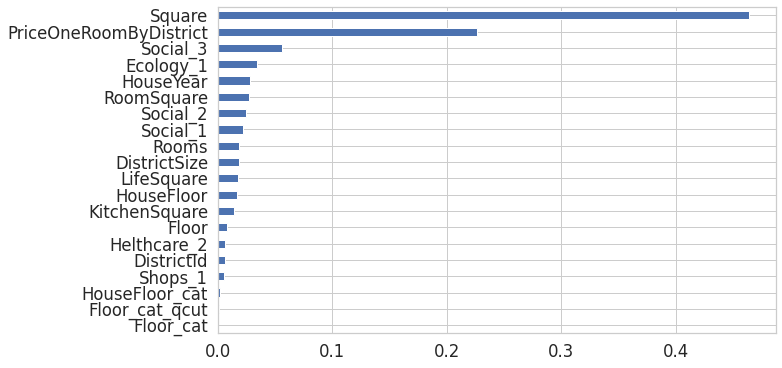

In [866]:
feat_importances.plot(kind='barh', figsize=(10, 6)); # RFE

## Прогнозирование на тестовом датасете

1. Выполнять для тестового датасета те же этапы обработки и построения признаков
2. Не потерять и не перемешать индексы тестового датасета при построении прогнозов
3. Прогнозы должны быть для всех примеров из тестового датасета

In [867]:
model.fit(X, y)
y_pred = model.predict(test_df[feature_names])
y_pred

array([158443.71527641, 231272.5159855 , 217821.48321153, ...,
       315554.18052354, 194255.14992054, 185506.52830771])

In [868]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"158,443.72"
1,15856,"231,272.52"
2,5480,"217,821.48"
3,15664,"356,732.44"
4,14275,"142,683.40"


In [869]:
preds.to_csv('ARusinov_predictions.csv', index=False)

Проверить точность предсказаний можно на https://www.kaggle.com/c/realestatepriceprediction/overview